In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import copy
import tensorflow as tf


### Dataset

Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository.  
https://doi.org/10.24432/C5F62R.

In [103]:
df = pd.read_csv("./../data/seoul_bike/SeoulBikeData.csv").drop(["Date","Holiday","Seasons"], axis=1)
df.columns = ["bike_count", "hour","temp","humidity","wind", "visibility", "dew_pt_temp","radiation","rain","snow","functional"]

df["functional"] = (df["functional"] == "Yes").astype(int) 
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [104]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [105]:
df.shape

(365, 10)

In [106]:
df["functional"].value_counts()

functional
1    353
0     12
Name: count, dtype: int64

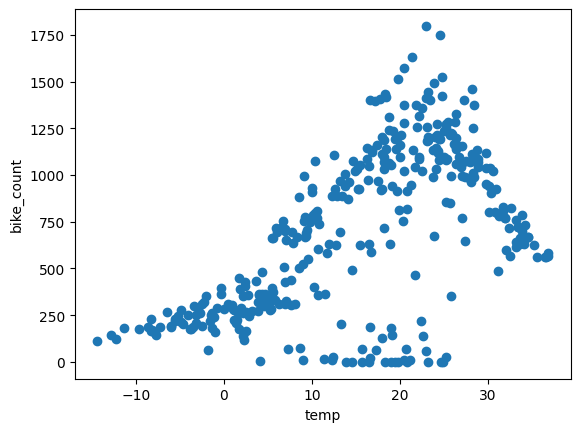

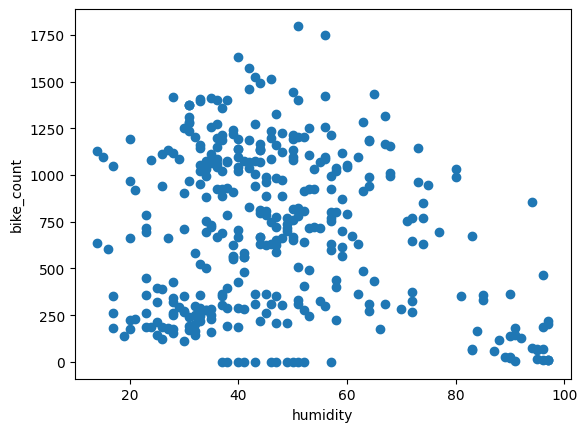

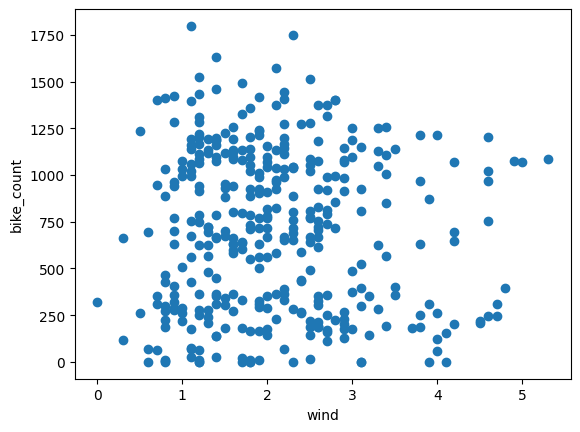

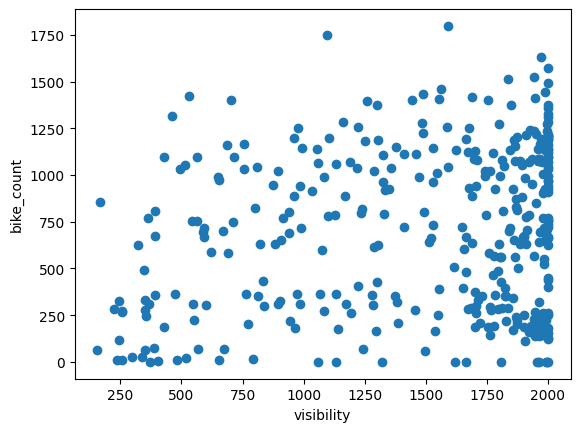

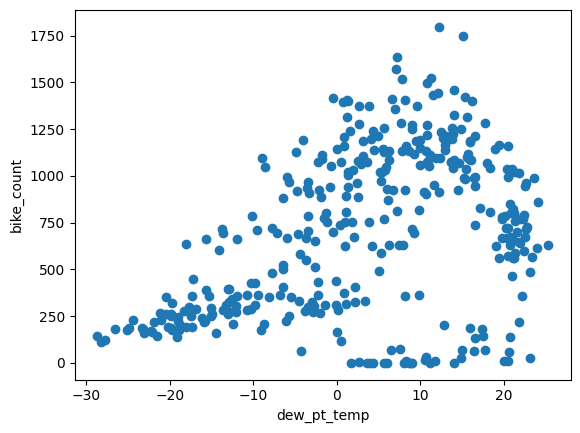

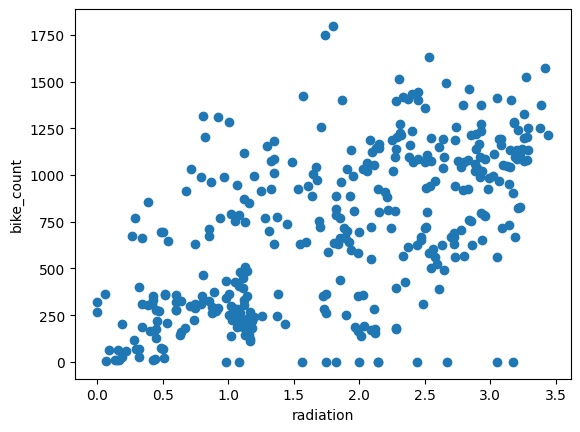

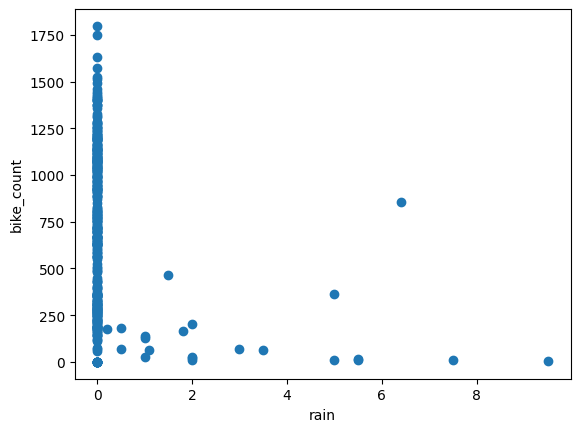

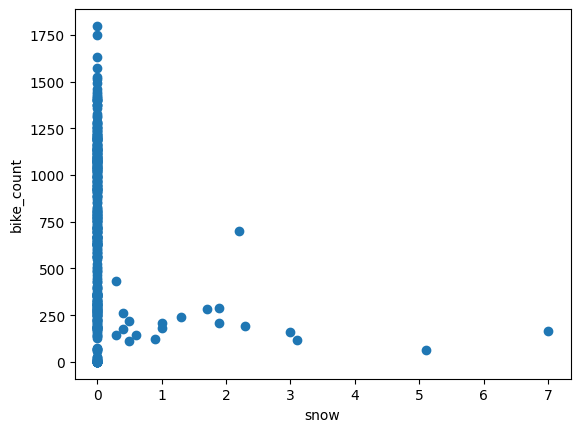

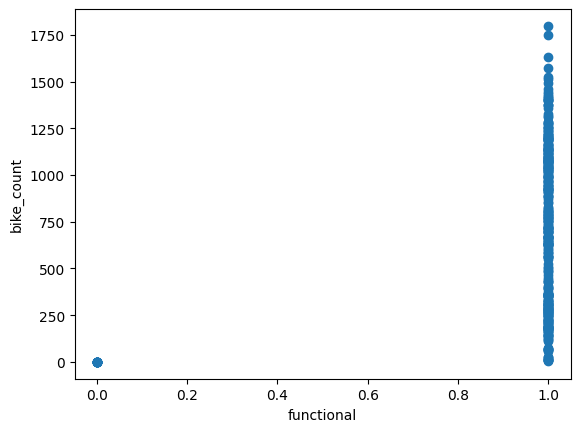

In [107]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.xlabel(label)
    plt.ylabel("bike_count")
    plt.show()

In [108]:
df = df.drop(["wind","visibility","functional"], axis=1)

In [109]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train, validation, test

In [110]:
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [111]:
def getXy(df, y_label, x_labels=None):
    dataframe = copy.deepcopy(df)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))
    return data, X, y

In [112]:
_, X_train_temp, y_train_temp = getXy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = getXy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = getXy(test, "bike_count", x_labels=["temp"])

In [113]:
temp_regressor = LinearRegression()
temp_regressor.fit(X_train_temp, y_train_temp)

LinearRegression()

In [114]:
print(temp_regressor.coef_, temp_regressor.intercept_)
temp_regressor.score(X_val_temp, y_val_temp)

[[20.57083477]] [380.49874913]


0.30674727010791536

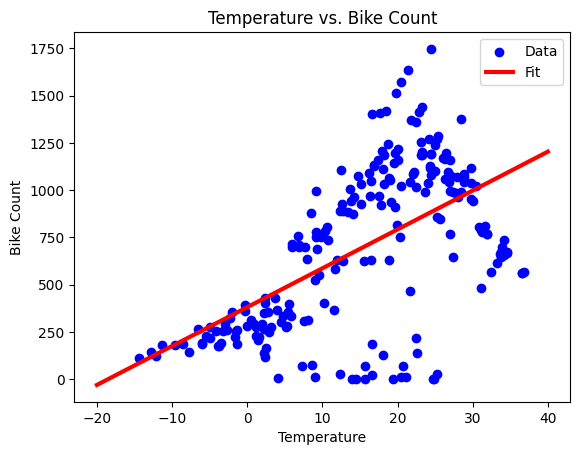

In [115]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_regressor.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs. Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

### Multi linear regression

In [116]:
_, X_train_all, y_train_all = getXy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = getXy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = getXy(test, "bike_count", x_labels=df.columns[1:])

In [117]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [118]:
print(all_reg.coef_, all_reg.intercept_)
all_reg.score(X_val_all, y_val_all)

[[-17.8384132  -12.82427011  36.70625031 151.77404843 -19.56403142
   -1.18430668]] [1194.98845308]


0.3017544652546995

### Regression with neural net

In [119]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [120]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [121]:
temp_nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

In [122]:
history = temp_nn_model.fit(X_train_temp.reshape(-1), y_train_temp, epochs=1000, verbose=0, validation_data=(X_val_temp, y_val_temp))

In [123]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


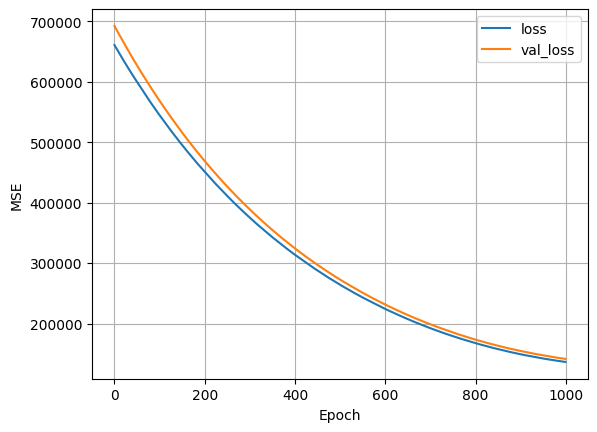

In [124]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


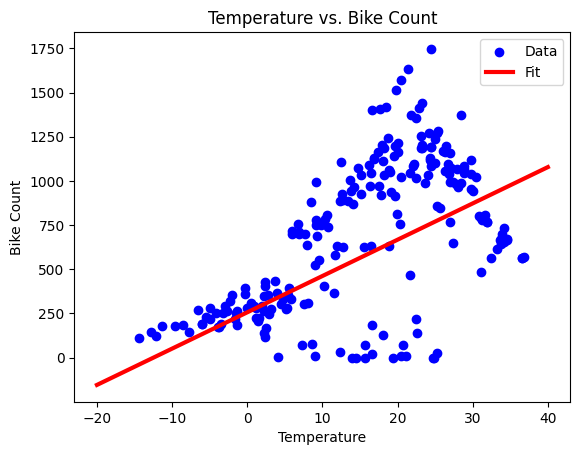

In [125]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs. Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

Neural Net

In [133]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="relu")
])

nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")

In [134]:
history = nn_model.fit(X_train_temp, y_train_temp, epochs=100, verbose=0, validation_data=(X_val_temp, y_val_temp))

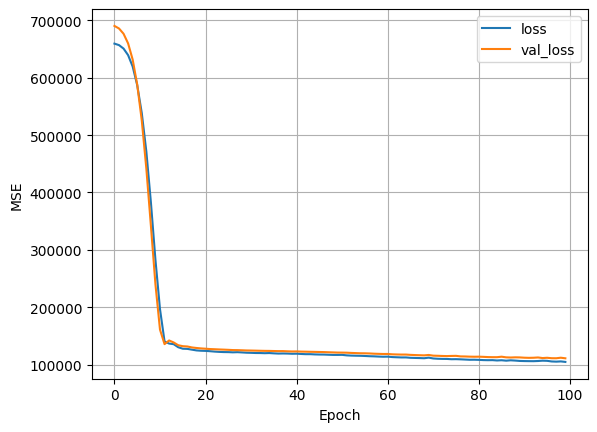

In [135]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


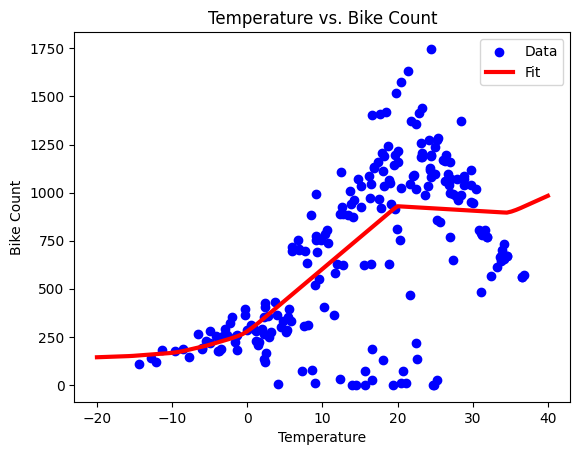

In [136]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs. Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

In [138]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="relu")
])

nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")

In [139]:
history = nn_model.fit(X_train_all, y_train_all, epochs=100, verbose=0, validation_data=(X_val_all, y_val_all))

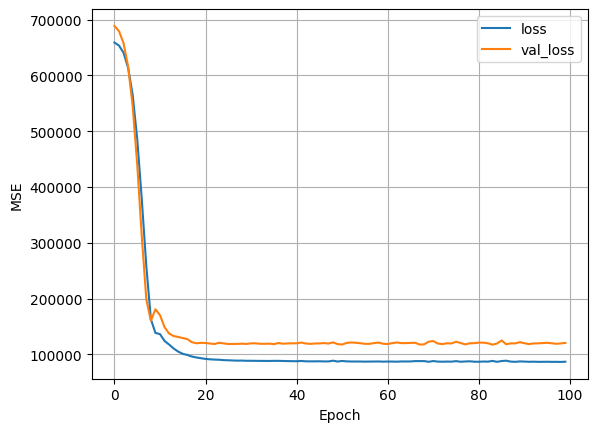

In [140]:
plot_loss(history)

4/4 [==============================] - 0s 1ms/step


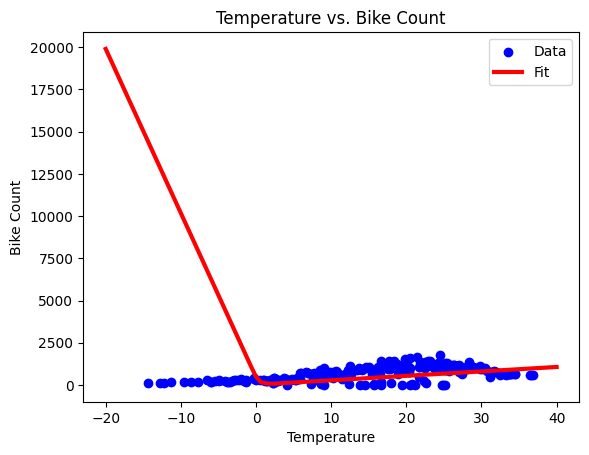

In [141]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Temperature vs. Bike Count")
plt.xlabel("Temperature")
plt.ylabel("Bike Count")
plt.show()

In [143]:
# Calculate MSE for linear regressor and neural network

y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 2ms/step


In [144]:
def MSE(y_pred, y_real):
    return np.mean((y_pred - y_real)**2)

In [145]:
MSE(y_pred_lr, y_test_all)


90958.45060958296

In [147]:
MSE(y_pred_nn, y_test_all)


93052.05172173007

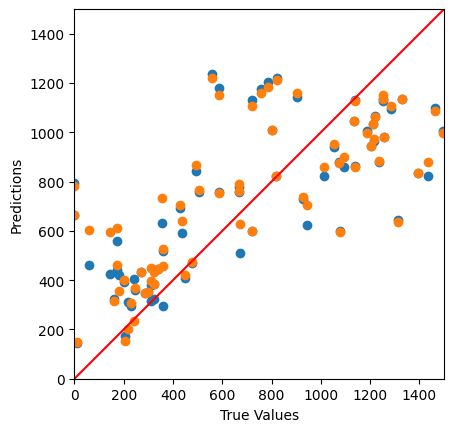

In [155]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Linear Regression")
plt.scatter(y_test_all, y_pred_nn, label="Neural Net Regression")

plt.xlabel("True Values")
plt.ylabel("Predictions")
limit = [0,1500]
plt.xlim(limit)
plt.ylim(limit)

_ = plt.plot(limit, limit, label="Perfect Fit", color="red")